# Tasks Day2 - Sequence Classification with Traditional NLP Methods

This notebook is mainly based on [this](https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy) blog post.

- Dataset: PubMed 200k RCT
- Methods: traditional machine learning classifier

## Data Preprocessing
Download the PubMed 20k RCT data with replaced numbers from the Git repository.

In [1]:
from pathlib import Path

data_dir='../data/PubMed_200k_RCT'
# check that the path is correct
Path(data_dir).mkdir(parents=True, exist_ok=True)

In [3]:
!wget -P $data_dir https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt
!wget -P $data_dir https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
!wget -P $data_dir https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt

--2022-08-02 16:50:16--  https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28908792 (28M) [text/plain]
Saving to: ‘/gdrive/MyDrive/ML_Handson_lab/g4-sentiment-biobert/data/raw/PubMed/train.txt.3’

train.txt.3         100%[===================>]  27.57M  44.7MB/s    in 0.6s    

2022-08-02 16:50:17 (44.7 MB/s) - ‘/gdrive/MyDrive/ML_Handson_lab/g4-sentiment-biobert/data/raw/PubMed/train.txt.3’ saved [28908792/28908792]

--2022-08-02 16:50:17--  https://raw.githubusercontent.com/Franck-Dernoncourt/pubmed-rct/master/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199

Convert the data to a pd.DataFrame for easier handling of the data. 

New documents start with _###_ empty lines indicate the end of a document. Within a line sentences and labels are separated by a tab.

In [2]:
import pandas as pd
from tqdm import tqdm
from os.path import join

def convert_to_df(file_path: str) -> pd.DataFrame:
    """Convert  documents to DataFrame

    Args:

        file_path (str): Path to train/dev/test files
    """
    instances = []
    with open(file_path, "r") as f:
        for line in tqdm(f.readlines(), desc=f"Process {file_path}"):
            if line.startswith("###") or len(line.strip()) == 0:
                next
            else:
                label, text = line.split("\t")
                instances.append({
                    "sentence": text,
                    "label": label
                })
    return pd.DataFrame(instances)

In [3]:
train = convert_to_df(join(data_dir, "train.txt"))
dev = convert_to_df(join(data_dir, "dev.txt"))
test = convert_to_df(join(data_dir, "test.txt"))

Process ../data/PubMed_200k_RCT\test.txt: 100%|██████████| 34493/34493 [00:00<00:00, 766197.23it/s]


### TASK: Tokenizer class or function

Implement a tokenizer class/function which...

- uses spacy/scispacy or nltk for parsing
- strips leading and trailing whitespaces
- converts everything to lowercase
- tokenizes the sentences
- removes stopwords and punctuations
- lemmatizes the tokens

In [4]:
import spacy
import string

In [8]:
from typing import List

"""
OPTIONAL: You can also implement it in your own way.
If you want to implement a tokenizer class you can use this template to start.
"""

class Tokenizer(object):
    def __init__(self):
        """
        Initialize the tokenizer with e.g. a spacy parser and a list of stop
        words and punctuation characters.
        """
        self.nlp = spacy.load("en_core_web_sm")
        self.stopwords = self.nlp.Defaults.stop_words
        self.punctuation = string.punctuation

    def __call__(self, sentence: str) -> List[str]:
        """Converts a sentence into a list of lemmatized tokens"""
        doc = self.nlp(''.join([c for c in sentence if c not in self.punctuation]))
        return [t.lemma_ for t in doc if t.text not in self.stopwords and not t.is_space]
        

In [9]:
Tokenizer()(sentence="Although I think the side effects are just my body$ getting to do what it wants to do without my anxiety trying to suppress it")

['although',
 'I',
 'think',
 'effect',
 'body',
 'get',
 'want',
 'anxiety',
 'try',
 'suppress']

### TASK (optional): Check for differences between spacy and scispacy parsing

### TASK: Initialize a sklearn vectorizer (e.g., CountVectorizer or TfidfVectorizer)

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

obj = Tokenizer()

train_sentences = train[:15000].sentence.tolist()
train_inputs = [' '.join(obj(sentence=text)) for text in train_sentences]
test_sentences = test[:3000].sentence.tolist()
test_inputs = [' '.join(obj(sentence=text)) for text in test_sentences]

tfidfvectorizer = TfidfVectorizer()
tfidf_wm_train = tfidfvectorizer.fit_transform(train_inputs)
tfidf_wm_test = tfidfvectorizer.transform(test_inputs)

Training features

In [28]:
import pickle

In [29]:
# save matrix
mat_dir='/gdrive/MyDrive/ML_Handson_lab/g4-sentiment-biobert/data/processed/'
filename = join(mat_dir, 'X_train.dat')
filehandler = open(filename,'wb')
pickle.dump(tfidf_wm_train.todense(), filehandler)
filehandler.close()

In [30]:
# load matrix
filehandler = open(filename, 'rb') 
X_train = pickle.load(filehandler)

In [31]:
X_train.shape

(15000, 15187)

Training labels

In [43]:
# save matrix
filename = join(mat_dir, 'y_train.dat')
filehandler = open(filename,'wb')
y_train = train[:15000].label.to_numpy()
pickle.dump(y_train, filehandler)
filehandler.close()

In [44]:
# load matrix
filehandler = open(filename, 'rb') 
y_train = pickle.load(filehandler)
filehandler.close()

In [45]:
y_train.shape

(15000,)

In [46]:
import numpy as np
np.unique(y_train)

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

Testing features

In [47]:
# save matrix
filename = join(mat_dir, 'X_test.dat')
filehandler = open(filename,'wb')
pickle.dump(tfidf_wm_test.todense(), filehandler)
filehandler.close()

In [48]:
# load matrix
filehandler = open(filename, 'rb') 
X_test = pickle.load(filehandler)

In [49]:
X_test.shape

(3000, 15187)

Testing labels

In [54]:
# save matrix
filename = join(mat_dir, 'y_test.dat')
filehandler = open(filename,'wb')
y_test = test[:3000].label.to_numpy()
pickle.dump(y_test, filehandler)
filehandler.close()

In [55]:
y_test.shape

(3000,)

### Model Training

### TASK: Train at least two models and compare their performances

You can choose any model you like but Logistic Regression, Naive Bayes, and 
Random Forest are good choices to start with.

In [52]:
import numpy as np
directory = '../results'

# Get training data and labels
X_train = np.asarray(np.load(join(directory,'X_train.dat'),allow_pickle=True))
y_train = np.asarray(np.load(join(directory,'y_train.dat'),allow_pickle=True))

# Get test data and labels
X_test = np.asarray(np.load(join(directory,'X_test.dat'),allow_pickle=True))
y_test = np.asarray(np.load(join(directory,'y_test.dat'),allow_pickle=True))

print(X_test.shape)
print(X_train.shape)

(3000, 15187)
(15000, 15187)


### Model I: Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.697


## Model II: Logistic Regression

In [67]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
clf1= LogisticRegression()
clf1.fit(X_train, y_train)
y_pred = clf1.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 0.731


### Model II: Support Vector Machine 

In [57]:
from sklearn.svm import SVC

#Create the svm classifier
clf = SVC(kernel='rbf')

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.742


### OPTIONAL TASK: Try to optimize the model hyperparameters

If you want to do this task, you can check out sklearn and look for Grid Search 
based optimization methods.

### Randomized GridSearch: Random Forest

#### Initialization of Parameter Grid

In [58]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# N_estimators: Number of trees in random forest
n_estimators = [200, 500, 700, 2000]

# Max Features: Number of features to consider at every split
max_features = ['sqrt']

# Max Depth: Maximum number of levels in tree
max_depth = [10, 50, 100]
max_depth.append(None)

# Min_Samples_Split: Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Min_Samples_Leaf: Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Boostrap: Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random parameter grid
random_param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_param_grid)

{'n_estimators': [200, 500, 700, 2000], 'max_features': ['sqrt'], 'max_depth': [10, 50, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


#### Training of Optimized Model

In [ ]:
# Create the base model to tune
clf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_random_CV = RandomizedSearchCV(
    estimator = clf,
    param_distributions = random_param_grid,
    n_iter = 60,
    cv = 3,
    verbose=2,
    random_state=42,
    n_jobs = -1)

# Fit the random search model
clf_random_CV.fit(X_train, y_train)

In [ ]:
#Show the best parameters
print(clf_random_CV.best_params_)

#Initialize new model
optimized_rf_clf = RandomForestClassifier()

#Set hyperparameters to be the optimized ones
optimized_rf_clf.set_params(**clf_random_CV.best_params_)

#Train model with optimized hyperparameters 
optimized_rf_clf.fit(X_train, y_train)

#Save predictions for rf
y_pred_optimized_rf = optimized_rf_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_optimized_rf))

### Randomized GridSearch: Support Vector Machine

#### Initialization of Parameter Grid

In [ ]:
# C: Number of trees in random forest
C = [0.2, 0.4, 0.6, 0.8, 1.0]

# Kernel: Specifies the kernel type to be used in the algorithm.
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

# Degree: Degree of the polynomial kernel function ('poly'). Ignored by all other kernels.
degree = [2,3,5,6,7]

# Gamma: Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
gamma = ['scale', 'auto']


# Create the random parameter grid
random_param_grid = {'C': C,
               'kernel': kernel,
               'degree': degree,
               'gamma': gamma}

print(random_param_grid)

#### Training of Optimized Model

In [ ]:
# Create the base model to tune
clf = SVC()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_random_CV = RandomizedSearchCV(
    estimator = clf,
    param_distributions = random_param_grid,
    n_iter = 60,
    cv = 3,
    verbose=2,
    random_state=42,
    n_jobs = -1)

# Fit the random search model
clf_random_CV.fit(X_train, y_train)

In [ ]:
#Show the best parameters
print(clf_random_CV.best_params_)

#Initialize new model
optimized_svm_clf = SVC()

#Set hyperparameters to be the optimized ones
optimized_svm_clf.set_params(**clf_random_CV.best_params_)

#Train model with optimized hyperparameters 
optimized_svm_clf.fit(X_train, y_train)

#Save predictions for rf
y_pred_optimized_svm = optimized_svm_clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred_optimized_svm))

### OPTIONAL TASK: Compare the performances of different vectorizers

Check if, for instance, CountVectorizers and TfidfVectorizers lead to different
performances.

In [ ]:
#CountVectorizer-optional
from sklearn.feature_extraction.text import CountVectorizer
obj1 = Tokenizer()

train_sentences = train[:1000].sentence.tolist()
train_inputs = [' '.join(obj1(sentence=text)) for text in train_sentences]
test_sentences = test[:200].sentence.tolist()
test_inputs = [' '.join(obj1(sentence=text)) for text in test_sentences]
vectorizer = CountVectorizer()

vect_count_train = vectorizer.fit_transform(train_inputs)
vect_count_test = vectorizer.transform(test_inputs)

In [ ]:
#saving matrix for CountVectorizer

mat_dir_countvec='/gdrive/MyDrive/ML_Handson_lab/g4-sentiment-biobert/data/processed/'
filename_vect = join(mat_dir_countvec, 'X_train_countvec.dat')
filehandler = open(filename_vect,'wb')
pickle.dump(vect_count_train.todense(), filehandler)
filehandler.close()

In [ ]:
# load matrix
filehandler = open(filename_vect, 'rb') 
X_train_countVec = pickle.load(filehandler)

In [ ]:
X_train_countVec.shape

(1000, 2960)

In [ ]:
# save matrix
filename_vect1 = join(mat_dir_countvec, 'y_train_countvec.dat')
filehandler = open(filename_vect1,'wb')
y_train_countVec = train[:1000].label.to_numpy()
pickle.dump(y_train_countVec, filehandler)
filehandler.close()

In [ ]:
# load matrix
filehandler = open(filename_vect1, 'rb') 
y_train_vec = pickle.load(filehandler)
filehandler.close()

In [ ]:
y_train_vec.shape

(1000,)

#### Testing features & Labels(CountVectorizer)

In [ ]:
#Featues
# save matrix
filename_test = join(mat_dir, 'X_test_countVec.dat')
filehandler = open(filename_test,'wb')
pickle.dump(tfidf_wm_test.todense(), filehandler)
filehandler.close()

# load matrix
filehandler = open(filename_test, 'rb') 
X_test_countVec = pickle.load(filehandler)

#Lables
# save matrix
filename_test1 = join(mat_dir, 'y_test_countVec.dat')
filehandler = open(filename_test1,'wb')
y_test_countVec = test[:200].label.to_numpy()
pickle.dump(y_test_countVec, filehandler)
filehandler.close()

## Visualize results

**Tasks:**

1. Show the classwise performance for at least two models.
2. Optional: Show the performances with respect to different parameters (only if hyperparameter optimization was performed)
3. Optional: Show the performances with respect to different tokenizers.
4. ...

In [60]:
import seaborn as sns
from sklearn.metrics import classification_report
import numpy as np

# Get rf predicition data
y_true_rf = y_test
y_pred_rf = y_pred

cl_report_rf = classification_report(y_test, y_pred, output_dict=True)
rf_report_df = pd.DataFrame(cl_report_rf).transpose()

In [61]:
# Get svm prediction data
y_true_svm = y_test
y_pred_svm = y_pred

cl_report_svm = classification_report(y_test,y_pred, output_dict=True)
svm_report_df = pd.DataFrame(cl_report_svm).transpose()

In [63]:
print('Classification Report RF:\n')
rf_report_df['label'] = rf_report_df.index
rf_report_df['classifier'] = 'rf'
rf_report_df

Classification Report RF:



,precision,recall,f1-score,support,label,classifier
BACKGROUND,0.681102,0.491477,0.570957,352.000,BACKGROUND,rf
CONCLUSIONS,0.596491,0.628176,0.611924,433.000,CONCLUSIONS,rf
METHODS,0.750216,0.893924,0.815789,971.000,METHODS,rf
OBJECTIVE,0.738562,0.518349,0.609164,218.000,OBJECTIVE,rf
RESULTS,0.816327,0.779727,0.797607,1026.000,RESULTS,rf
accuracy,0.742000,0.742000,0.742000,0.742,accuracy,rf
macro avg,0.716540,0.662330,0.681088,3000.000,macro avg,rf
weighted avg,0.741682,0.742000,0.736405,3000.000,weighted avg,rf


In [64]:
print('Classification Report SVM:\n')
svm_report_df['label'] = svm_report_df.index
svm_report_df['classifier'] = 'svm'
svm_report_df

Classification Report SVM:



,precision,recall,f1-score,support,label,classifier
BACKGROUND,0.681102,0.491477,0.570957,352.000,BACKGROUND,svm
CONCLUSIONS,0.596491,0.628176,0.611924,433.000,CONCLUSIONS,svm
METHODS,0.750216,0.893924,0.815789,971.000,METHODS,svm
OBJECTIVE,0.738562,0.518349,0.609164,218.000,OBJECTIVE,svm
RESULTS,0.816327,0.779727,0.797607,1026.000,RESULTS,svm
accuracy,0.742000,0.742000,0.742000,0.742,accuracy,svm
macro avg,0.716540,0.662330,0.681088,3000.000,macro avg,svm
weighted avg,0.741682,0.742000,0.736405,3000.000,weighted avg,svm


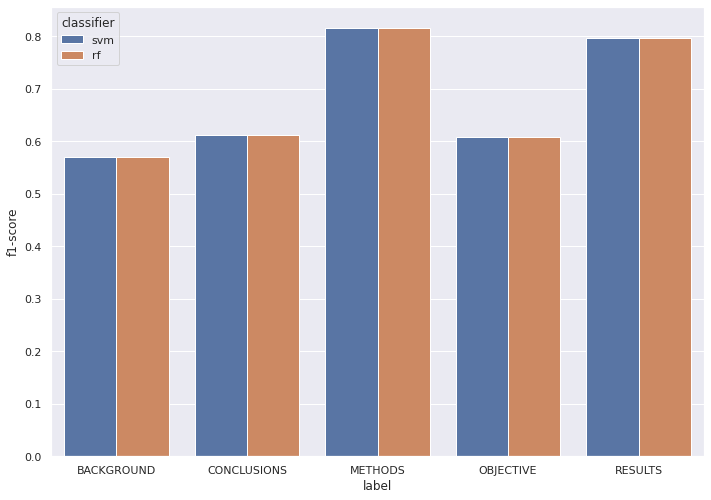

In [65]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

plot_df = pd.concat([svm_report_df.head(), rf_report_df.head()])

ax = sns.barplot(x="label", y="f1-score", hue="classifier", data=plot_df)

### **Visualizing results of Optimized model**

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get rf predicition data
y_true_rf = y_test
y_pred_rf = y_pred_optimized_rf

# Get svm prediction data
y_true_svm = y_test
y_pred_svm = y_pred_optimized_svm

cl_report_rf = classification_report(y_test, y_pred_optimized_rf, output_dict=True)
rf_report_df = pd.DataFrame(cl_report_rf).transpose()

cl_report_svm = classification_report(y_test, y_pred_optimized_svm, output_dict=True)
svm_report_df = pd.DataFrame(cl_report_svm).transpose()

In [ ]:
print('Classification Report RF:\n')
rf_report_df['label'] = rf_report_df.index
rf_report_df['classifier'] = 'rf'
rf_report_df

In [ ]:
print('Classification Report SVM:\n')
svm_report_df['label'] = svm_report_df.index
svm_report_df['classifier'] = 'svm'
svm_report_df

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

plot_df = pd.concat([svm_report_df.head(), rf_report_df.head()])

ax = sns.barplot(x="label", y="f1-score", hue="classifier", data=plot_df)

## Conclusion

Data pre-processing includes various tasks such as getting data into proper formate, tokenization and Vectorize it by  CountVectorizer or TfidfVectorizer. We found that CountVectorizer performs the task of tokenizing and counting, while TfidfTransformer normalizes the data and weighting it with diminishing importance of tokens that occur in the majority of documents.

Data pre-processing was performed and followed by model buiding part where different ML methods such as SVM, Logistic Regression and Random Forest were used to analyze the given data. Optimization is done to tune the hyperparameters to find the right combination of hyperparameter values to achieve maximum performance on the data in a reasonable amount of time.

We conculde that highest accuracy is obtained by SVM model and then logistic regression and RF. 

Performace can be increased by using whole dataset.